(example_02_synthetic_natural_image_patches)=

# Synthetic Natural Image Patches

A example application of the `circle_bundles` pipeline to a dataset with the topology of a Klein bottle.

We generate a synthetic sample of high-contrast $n\times n$ optical image patches from a known model (see -- for details) and choose an $\mathbb{RP}^{1}$-valued feature map for analysis.  We compute characteristic classes to confirm the non-orientable global topology of the underlying model, then construct a coordinate system which reflects the inherent non-orientability. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from ripser import ripser
from persim import plot_diagrams

import circle_bundles as cb

Generate the dataset and treat patches as vectors in $\mathbb{R}^{n^{2}}$

In [2]:
n_patches = 5000  
n = 3   #Choose a patch size

rng = np.random.default_rng(0)
data = cb.sample_nat_img_kb(n_patches, n = n, rng = rng)[0]  

#Create a patch visualizer function
patch_vis = cb.make_patch_visualizer()

We define a projection map which returns the 'predominant gradient direction' of a high-contrast patch.  Compute the predominant gradient direction of each patch:

In [3]:
grad_dirs = cb.get_gradient_dirs(data)[0].reshape(-1,1)   

View a small random sample of the dataset arranged by gradient direction:

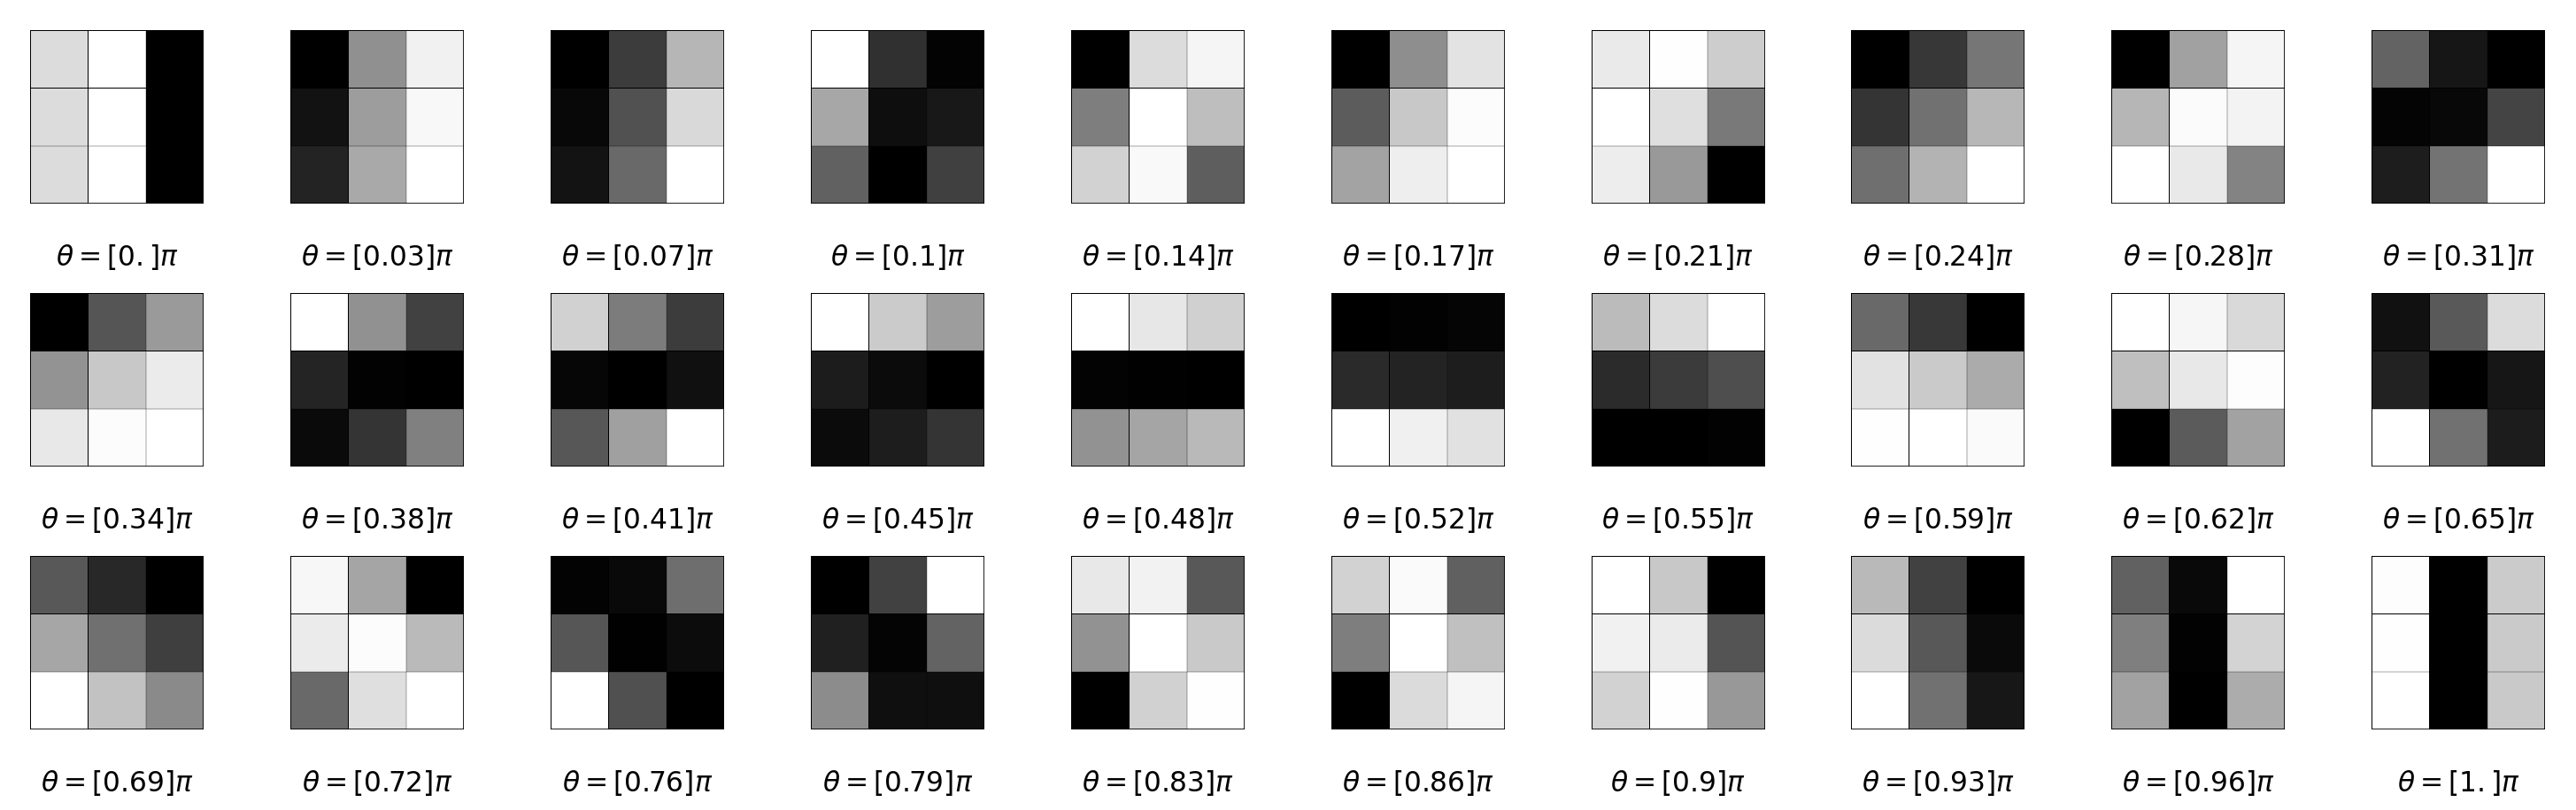

In [4]:
n_samples = 30

label_func = [fr"$\theta = {np.round(grad/np.pi, 2)}$" + r"$\pi$" for grad in grad_dirs]

fig = cb.show_data_vis(
    data, 
    patch_vis, 
    label_func = label_func, 
    angles = grad_dirs, 
    sampling_method = 'angle', 
    max_samples = n_samples)
plt.show()


Compute persistence diagrams over $\mathbb{Z}_{2}$ and $\mathbb{Z}_{3}$ for a sample of the dataset


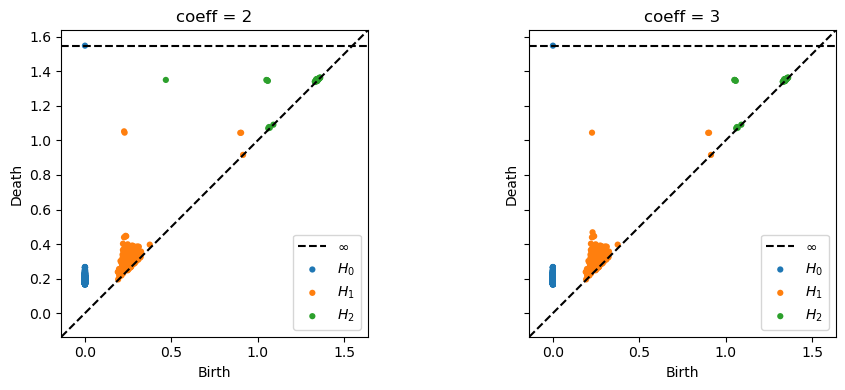

In [5]:
dgms_2 = ripser(data, coeff=2, maxdim=2, n_perm=500)["dgms"]
dgms_3 = ripser(data, coeff=3, maxdim=2, n_perm=500)["dgms"]

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)

plot_diagrams(dgms_2, ax=axes[0], title="coeff = 2")
plot_diagrams(dgms_3, ax=axes[1], title="coeff = 3")

plt.tight_layout()
plt.show()


Note the $\mathbb{Z}_{2}$ diagram has two 1-dimensional persistent classes and one 2-dimensional persistent class, but the $\mathbb{Z}_{3}$ diagram has a single 1-dimensional persistent classes and no 2-dimensional persistent classes. This is consistent with the homology of the Klein bottle, as expected. 

To apply local-to-global analysis, construct a cover of the base space $\mathbb{RP}^{1}$ by metric balls $\{U_{j}\}_{j=1}^{12}$ around equally-spaced landmarks:

In [6]:
n_landmarks = 12
landmarks = np.linspace(0, np.pi,n_landmarks, endpoint= False).reshape(-1,1)
overlap = 1.4

radius = overlap* np.pi/(2*n_landmarks)

cover = cb.get_metric_ball_cover(grad_dirs.reshape(-1,1), 
                                 landmarks, 
                                 radius = radius, 
                                 metric = cb.RP1AngleMetric())


Compute a persistence diagram for the data in each set $\pi^{-1}(U_{j})$:

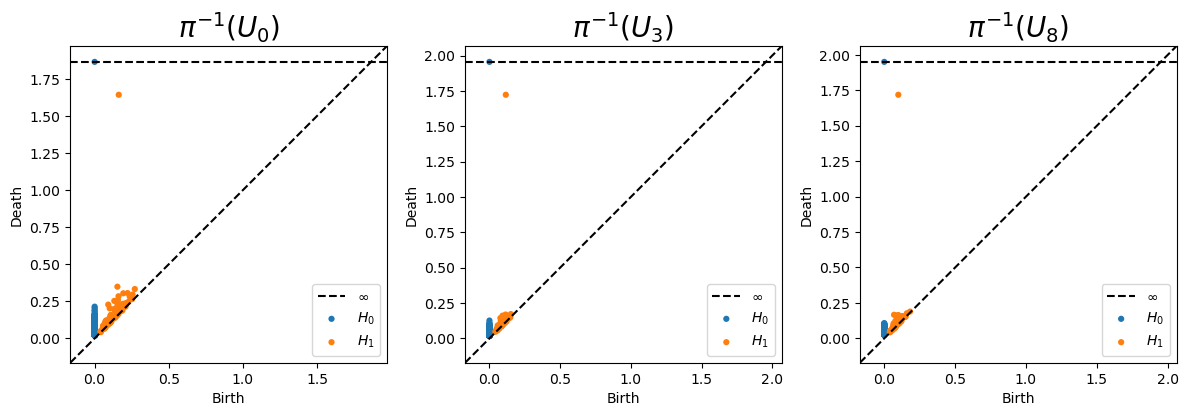

In [7]:
fiber_ids, dense_idx_list, rips_list = cb.get_local_rips(
    data,
    cover.U,
    to_view = [0,3,8], #Choose a few diagrams to compute 
                       #(or compute all by setting to None)
    maxdim=1,
    n_perm=500,
    random_state=None,
)

fig, axes = cb.plot_local_rips(
    fiber_ids,
    rips_list,
    n_cols=3,
    titles='default',
    font_size=20,
)

Observe that each $\pi^{-1}(U_{j})$ has a single 1-dimensional (circular) persistent feature, supporting the hypothesis that the data has the structure of a discrete approximate circle bundle over $\mathbb{RP}^{1}$. Up to isomorphism, the only circle bundles over $\mathbb{RP}^{1}\cong\mathbb{S}^{1}$ are the torus (trivial) and the Klein bottle (non-orientable). These two possibilities are distinguished by the orientation class $w_{1}$.

Construct a bundle object. Compute local circular coordinates and approximate transition matrices: 

In [15]:
bundle = cb.Bundle(X = data, cover = cover)
triv_result = bundle.get_local_trivs(show_summary = True)

<IPython.core.display.Math object>

Now, compute characteristic class info:

In [16]:
class_result = bundle.get_classes(show_summary = True)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

The results above confirm the non-trivial global structure, so a global trivialization is not possible here. On the other hand, as indicated by the class persistence table, the $w_{1}$ class representative restricts to a coboundary once an edge is removed from the nerve of the cover (indeed, any cocycle is a coboundary on this subcomplex). 

Remove an edge from the nerve of the open cover (corresponding to the set intersection with the poorest Procrustes alignment quality), and compute coordinates which reflect this cut:  

In [17]:
global_triv_result = bundle.get_global_trivialization()

Show a visualization of the nerve of the open cover with edges decorated by the values of the computed orientation cocycle representative (shown in blue).  The 'weight' assigned to each edge, measuring the quality of Procrustes alignment on the corresponding set intersection, is shown. The edge which was removed for coordinatization is indicated, and a potential for the orientation cocycle after restriction to the reduced nerve is shown in red. 

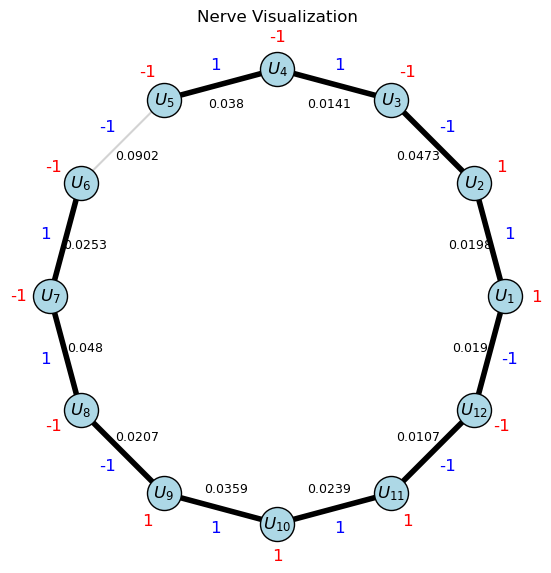

In [18]:
fig = bundle.show_circle_nerve()
plt.show()

Now, show a sample of coordinatized patches from the dataset:

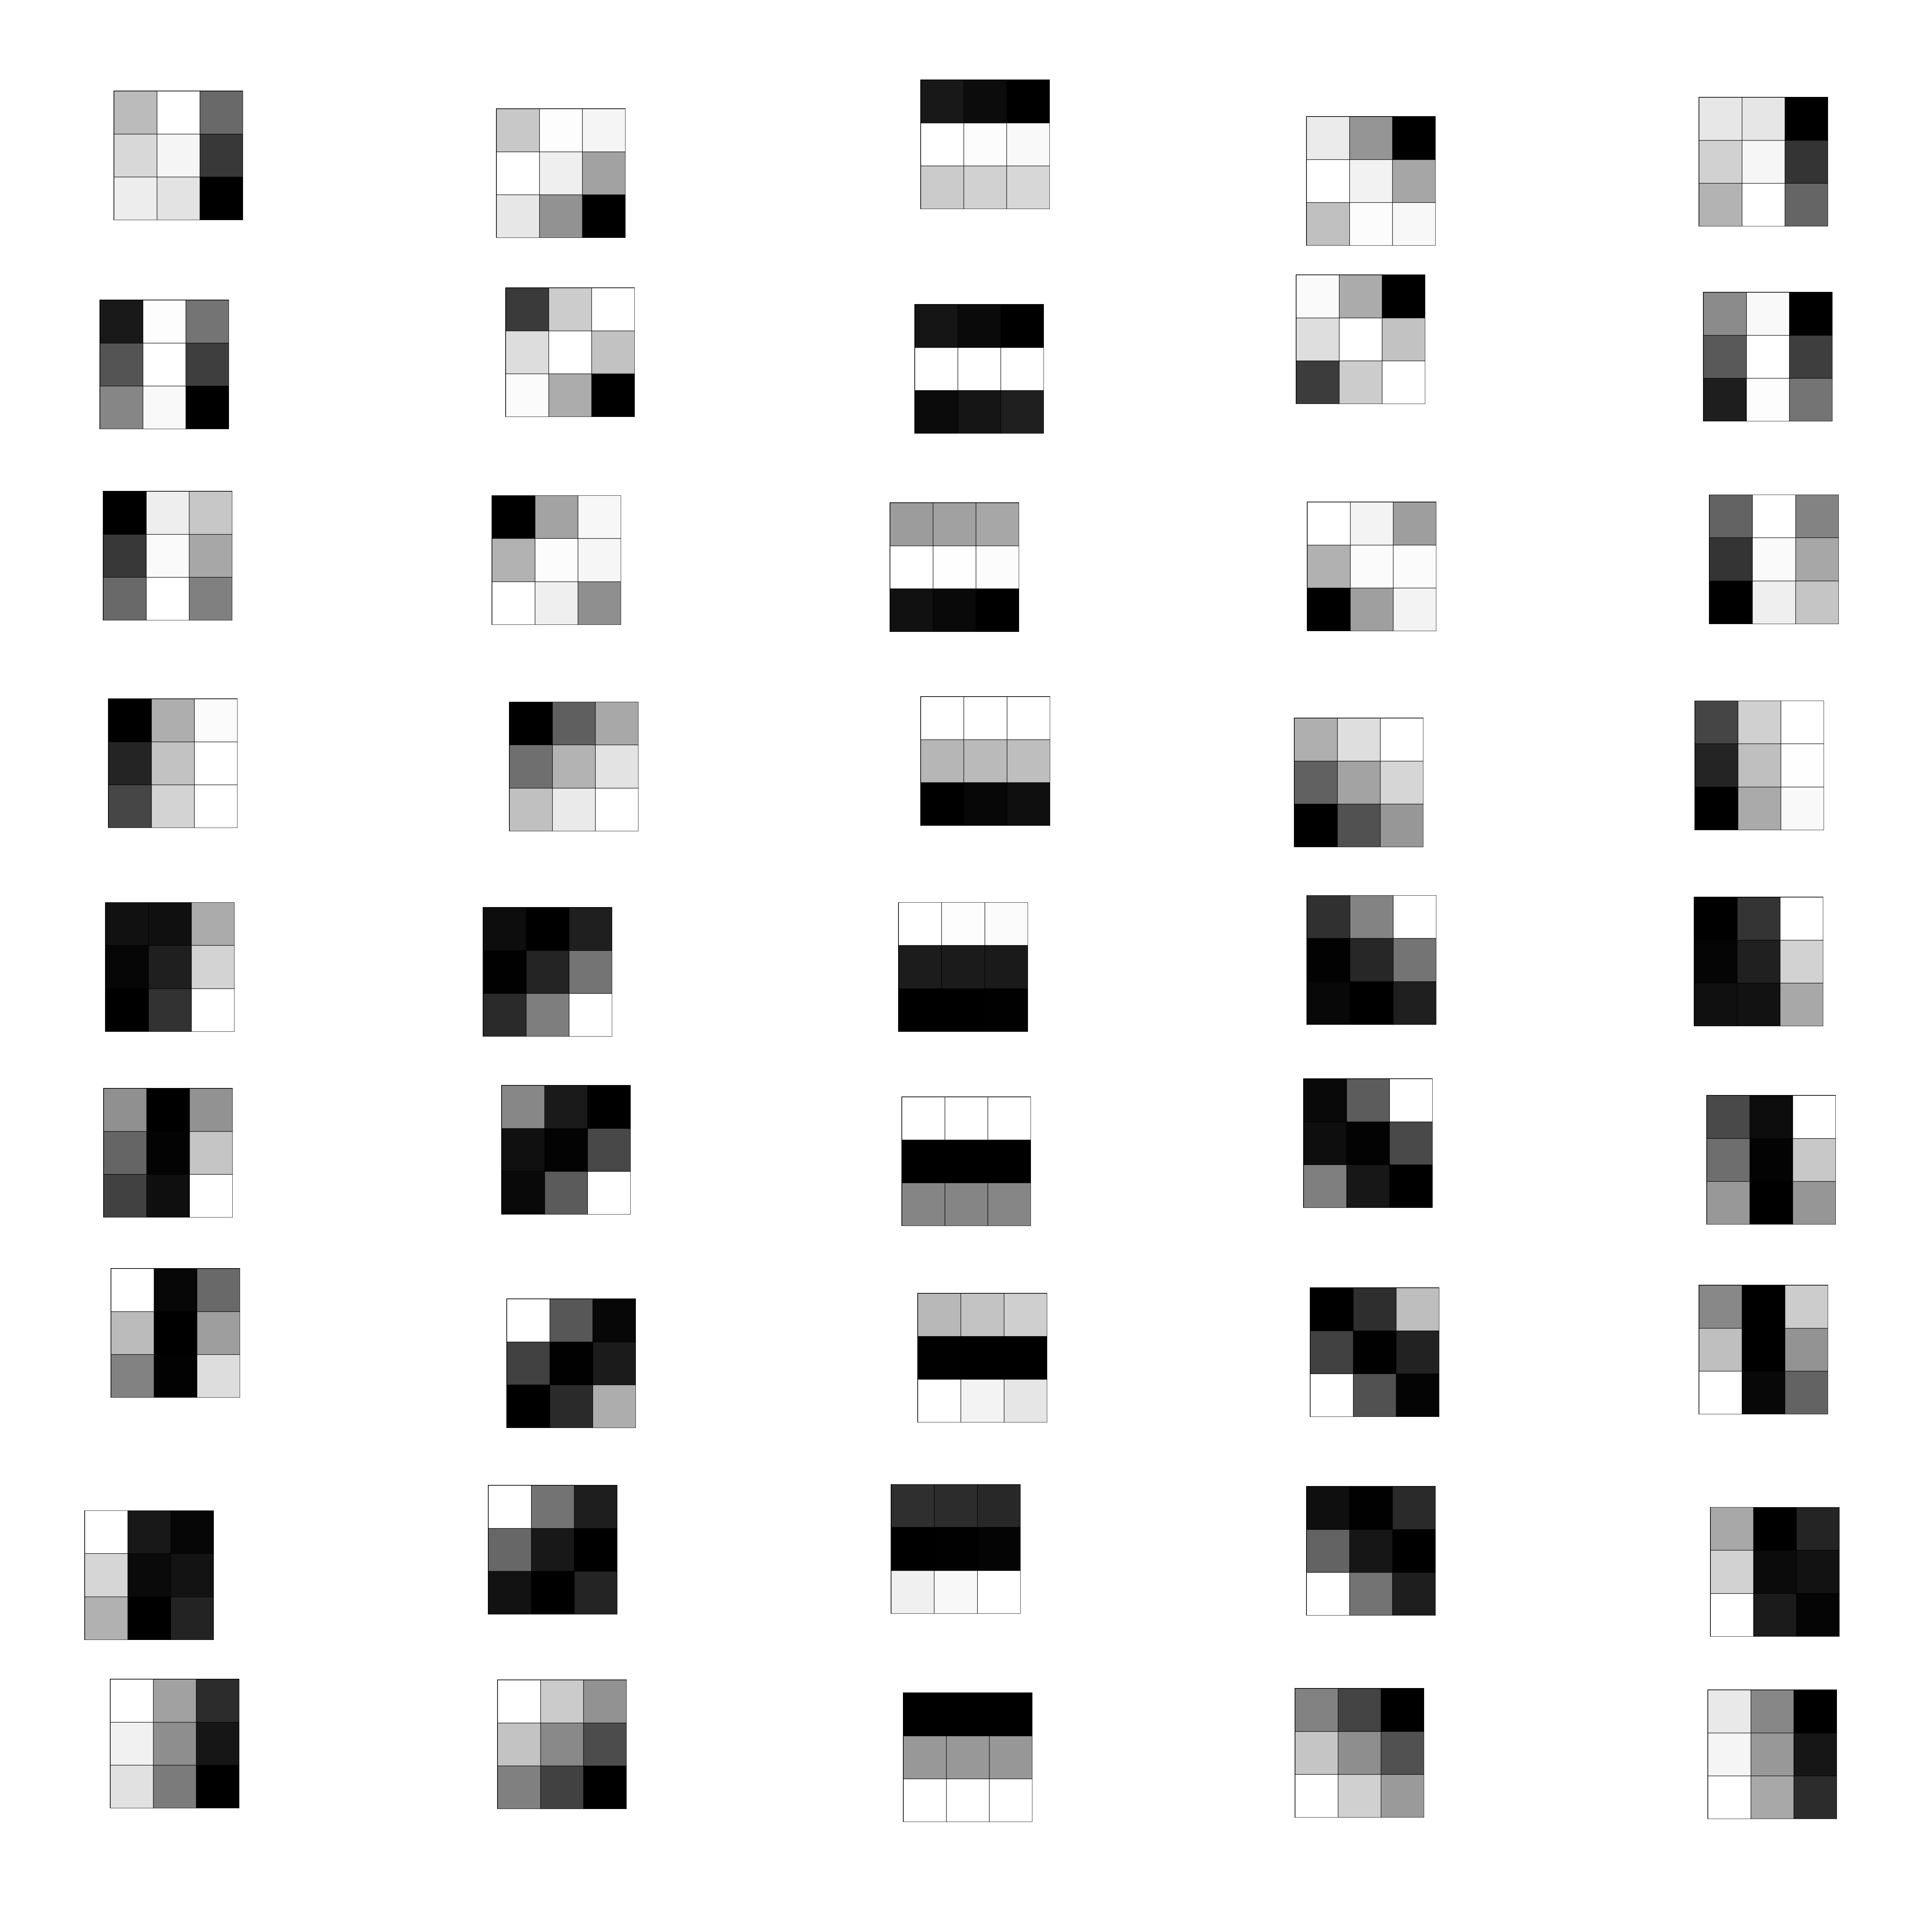

In [20]:
per_row = 5
per_col = 9
coords = np.column_stack([grad_dirs.reshape(-1,1), global_triv_result.reshape(-1,1)])

fig = cb.lattice_vis(
    data,
    coords,
    patch_vis,
    per_row=per_row,
    per_col = per_col,
    figsize=19,
    thumb_px=350,   
    dpi=350         
)

plt.show()


Notice the abrupt reflection in the coordinates between columns 2 and 3 in the diagram above. Everywhere else, the coordinate system varies continuously, and the edges of the diagram roughly coincide. 